# Chicago Divvy Bicycle Sharing Data

#### Link Kaggle
https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data

#### Descrição das features:
<br><b>trip_idID</b> attached to each trip taken
<br><b>year</b>
<br><b>month</b>
<br><b>week</b> week No.
<br><b>day</b> 
<br><b>hour</b> 
<br><b>usertype</b> "Customer" is a rider who purchased a 24-Hour Pass; "Subscriber" is a rider who purchased an Annual Membership
<br><b>gender</b>
<br><b>starttimeday</b> and time trip started, in CST
<br><b>stoptimeday</b> and time trip ended, in CST
<br><b>tripdurationtime</b> of trip in minutes
<br><b>temperature</b>
<br><b>events</b>
<br><b>from_station_idID</b> of station where trip originated
<br><b>from_station_namename</b> of station where trip terminated
<br><b>latitude_startstation</b> latitude
<br><b>longitude_startstation</b> longitude
<br><b>dpcapacity_startnumber</b> of total docks at each station
<br><b>to_station_id</b>
<br><b>to_station_name</b>
<br><b>latitude_end</b>
<br><b>longitude_end</b>
<br><b>dpcapacity_endnumber</b> of total docks at each station

### Bibliotecas

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, BatchNormalization, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras import callbacks

import warnings

#warnings.filterwarnings('ignore')

### Carregar dataset

In [4]:
#Carregar dataset
path = "data.csv"
df = pd.read_csv(path)

df.shape

(9495235, 23)

### Correções

In [5]:
#Corringindo campo day com 0
df.day =  df.starttime.astype(str).str.slice(8,10).astype(int)

### Novas Features

In [6]:
#Campo data
df['date'] = df.starttime.astype(str).str[:13]  + ':00:00'

#Convertendo para datetime
df.date = pd.to_datetime(df.date)

### Consolidando dados

In [7]:
#Agregação por date
df2 =  df.groupby(['date']).size().reset_index(name='count')

#Date como index
df2.index = df2['date']
del df2['date']

df2.head(5)
df2.tail(5)

,count
date,
2017-12-31 17:00:00,38
2017-12-31 18:00:00,27
2017-12-31 20:00:00,19
2017-12-31 22:00:00,9
2017-12-31 23:00:00,7


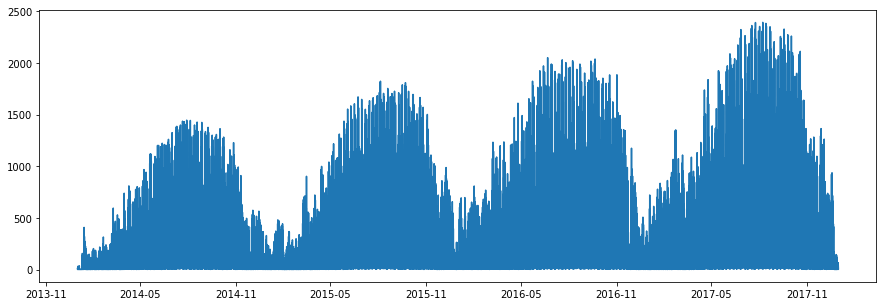

In [8]:
plt.figure(figsize = (15, 5))
plt.plot(df2)
plt.show()

### Normalizando features

In [9]:
values = df2['count'].values.reshape(-1,1)
values = values.astype('float32')
f_norm = MinMaxScaler(feature_range=(0, 1))
v_norm = f_norm.fit_transform(values)

### Particionando Sets

In [11]:
#Definindo o tamanho de cada set
train_size = int(len(v_norm) * 0.8)
test_size  = (5*24)
val_size   = len(v_norm) - train_size - test_size

#Particionando os sets
train = v_norm[0:train_size,:]
val   = v_norm[train_size:(train_size+val_size),:]
test  = v_norm[(train_size+val_size):len(v_norm),:]

#Volume de dados
print('Train:', len(train))
print('Val:  ', len(val))
print('Test: ', len(test))

Train: 27693
Val:   6804
Test:  120


### Definindo Modelo

In [43]:
batch_size=2
time_steps=24

trainGenerator = TimeseriesGenerator(train, train,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
valGenerator = TimeseriesGenerator(val,  val,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
testGenerator = TimeseriesGenerator(test,  test,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)

#Reshape
#trainX_ = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#valX_   = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

#Dfinindo modelo LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(time_steps, train.shape[1])))

#model.add(Dropout(0.2))
#model.add(Dense(128))
#model.add(BatchNormalization())

model.add(Dense(1))

print(model.summary())

#Compilando Modelo
model.compile(loss='mean_squared_error', optimizer='adam')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
None


### Treinando Modelo

In [44]:
epochs = 500
batch_size = 300

#Fit nos dados
history = model.fit_generator(trainGenerator, 
                    steps_per_epoch= 30, 
                    epochs = epochs,
                    validation_data = valGenerator,
                    callbacks=[
                        callbacks.EarlyStopping(patience=100),
                        callbacks.ModelCheckpoint('best.2.h5', save_best_only=True, save_weights_only=True, verbose=1)
                    ])

model.load_weights('best.2.h5')

#history = model.fit(trainX_, trainY, epochs=epochs, batch_size=batch_size, validation_data=(valX_, valY))

Epoch 1/500
30/30 [==============================] - 16s 542ms/step - loss: 0.0187 - val_loss: 0.0264

Epoch 00001: val_loss improved from inf to 0.02641, saving model to best.2.h5
Epoch 2/500
30/30 [==============================] - 15s 495ms/step - loss: 0.0086 - val_loss: 0.0244

Epoch 00002: val_loss improved from 0.02641 to 0.02436, saving model to best.2.h5
Epoch 3/500
30/30 [==============================] - 14s 457ms/step - loss: 0.0081 - val_loss: 0.0237

Epoch 00003: val_loss improved from 0.02436 to 0.02371, saving model to best.2.h5
Epoch 4/500
30/30 [==============================] - 14s 461ms/step - loss: 0.0102 - val_loss: 0.0204

Epoch 00004: val_loss improved from 0.02371 to 0.02038, saving model to best.2.h5
Epoch 5/500
30/30 [==============================] - 14s 468ms/step - loss: 0.0120 - val_loss: 0.0190

Epoch 00005: val_loss improved from 0.02038 to 0.01896, saving model to best.2.h5
Epoch 6/500
30/30 [==============================] - 14s 472ms/step - loss: 0.0

30/30 [==============================] - 14s 469ms/step - loss: 0.0033 - val_loss: 0.0073

Epoch 00049: val_loss did not improve from 0.00721
Epoch 50/500
30/30 [==============================] - 14s 473ms/step - loss: 0.0019 - val_loss: 0.0073

Epoch 00050: val_loss did not improve from 0.00721
Epoch 51/500
30/30 [==============================] - 14s 468ms/step - loss: 0.0037 - val_loss: 0.0069

Epoch 00051: val_loss improved from 0.00721 to 0.00692, saving model to best.2.h5
Epoch 52/500
30/30 [==============================] - 14s 462ms/step - loss: 0.0026 - val_loss: 0.0076

Epoch 00052: val_loss did not improve from 0.00692
Epoch 53/500
30/30 [==============================] - 14s 461ms/step - loss: 0.0038 - val_loss: 0.0067

Epoch 00053: val_loss improved from 0.00692 to 0.00673, saving model to best.2.h5
Epoch 54/500
30/30 [==============================] - 14s 466ms/step - loss: 0.0027 - val_loss: 0.0067

Epoch 00054: val_loss improved from 0.00673 to 0.00668, saving model to 

30/30 [==============================] - 14s 457ms/step - loss: 0.0018 - val_loss: 0.0052

Epoch 00099: val_loss did not improve from 0.00447
Epoch 100/500
30/30 [==============================] - 14s 457ms/step - loss: 0.0014 - val_loss: 0.0059

Epoch 00100: val_loss did not improve from 0.00447
Epoch 101/500
30/30 [==============================] - 14s 456ms/step - loss: 0.0045 - val_loss: 0.0045

Epoch 00101: val_loss improved from 0.00447 to 0.00446, saving model to best.2.h5
Epoch 102/500
30/30 [==============================] - 14s 470ms/step - loss: 0.0015 - val_loss: 0.0041

Epoch 00102: val_loss improved from 0.00446 to 0.00405, saving model to best.2.h5
Epoch 103/500
30/30 [==============================] - 14s 469ms/step - loss: 0.0024 - val_loss: 0.0044

Epoch 00103: val_loss did not improve from 0.00405
Epoch 104/500
30/30 [==============================] - 14s 466ms/step - loss: 8.2456e-04 - val_loss: 0.0045

Epoch 00104: val_loss did not improve from 0.00405
Epoch 105/50

30/30 [==============================] - 14s 450ms/step - loss: 0.0013 - val_loss: 0.0035

Epoch 00150: val_loss improved from 0.00357 to 0.00349, saving model to best.2.h5
Epoch 151/500
30/30 [==============================] - 14s 464ms/step - loss: 8.9769e-04 - val_loss: 0.0034

Epoch 00151: val_loss improved from 0.00349 to 0.00340, saving model to best.2.h5
Epoch 152/500
30/30 [==============================] - 14s 470ms/step - loss: 0.0032 - val_loss: 0.0036

Epoch 00152: val_loss did not improve from 0.00340
Epoch 153/500
30/30 [==============================] - 14s 462ms/step - loss: 0.0037 - val_loss: 0.0057

Epoch 00153: val_loss did not improve from 0.00340
Epoch 154/500
30/30 [==============================] - 14s 474ms/step - loss: 0.0024 - val_loss: 0.0048

Epoch 00154: val_loss did not improve from 0.00340
Epoch 155/500
30/30 [==============================] - 14s 463ms/step - loss: 0.0024 - val_loss: 0.0040

Epoch 00155: val_loss did not improve from 0.00340
Epoch 156/50


Epoch 00201: val_loss did not improve from 0.00283
Epoch 202/500
30/30 [==============================] - 14s 470ms/step - loss: 0.0026 - val_loss: 0.0029

Epoch 00202: val_loss did not improve from 0.00283
Epoch 203/500
30/30 [==============================] - 14s 473ms/step - loss: 0.0021 - val_loss: 0.0030

Epoch 00203: val_loss did not improve from 0.00283
Epoch 204/500
30/30 [==============================] - 14s 458ms/step - loss: 0.0011 - val_loss: 0.0039

Epoch 00204: val_loss did not improve from 0.00283
Epoch 205/500
30/30 [==============================] - 14s 470ms/step - loss: 0.0019 - val_loss: 0.0029

Epoch 00205: val_loss did not improve from 0.00283
Epoch 206/500
30/30 [==============================] - 14s 475ms/step - loss: 0.0011 - val_loss: 0.0027

Epoch 00206: val_loss improved from 0.00283 to 0.00267, saving model to best.2.h5
Epoch 207/500
30/30 [==============================] - 14s 457ms/step - loss: 0.0023 - val_loss: 0.0027

Epoch 00207: val_loss improved f

30/30 [==============================] - 14s 468ms/step - loss: 0.0013 - val_loss: 0.0029

Epoch 00253: val_loss did not improve from 0.00222
Epoch 254/500
30/30 [==============================] - 14s 466ms/step - loss: 0.0015 - val_loss: 0.0028

Epoch 00254: val_loss did not improve from 0.00222
Epoch 255/500
30/30 [==============================] - 15s 485ms/step - loss: 9.9425e-04 - val_loss: 0.0030

Epoch 00255: val_loss did not improve from 0.00222
Epoch 256/500
30/30 [==============================] - 14s 460ms/step - loss: 0.0010 - val_loss: 0.0035

Epoch 00256: val_loss did not improve from 0.00222
Epoch 257/500
30/30 [==============================] - 14s 462ms/step - loss: 7.8986e-04 - val_loss: 0.0034

Epoch 00257: val_loss did not improve from 0.00222
Epoch 258/500
30/30 [==============================] - 14s 472ms/step - loss: 0.0021 - val_loss: 0.0024

Epoch 00258: val_loss did not improve from 0.00222
Epoch 259/500
30/30 [==============================] - 14s 457ms/step 

30/30 [==============================] - 14s 460ms/step - loss: 0.0017 - val_loss: 0.0024

Epoch 00305: val_loss did not improve from 0.00222
Epoch 306/500
30/30 [==============================] - 14s 455ms/step - loss: 0.0011 - val_loss: 0.0028

Epoch 00306: val_loss did not improve from 0.00222
Epoch 307/500
30/30 [==============================] - 14s 462ms/step - loss: 0.0032 - val_loss: 0.0029

Epoch 00307: val_loss did not improve from 0.00222
Epoch 308/500
30/30 [==============================] - 14s 470ms/step - loss: 0.0010 - val_loss: 0.0029

Epoch 00308: val_loss did not improve from 0.00222
Epoch 309/500
30/30 [==============================] - 14s 472ms/step - loss: 0.0012 - val_loss: 0.0026

Epoch 00309: val_loss did not improve from 0.00222
Epoch 310/500
30/30 [==============================] - 14s 477ms/step - loss: 0.0020 - val_loss: 0.0028

Epoch 00310: val_loss did not improve from 0.00222
Epoch 311/500
30/30 [==============================] - 14s 470ms/step - loss: 

30/30 [==============================] - 14s 460ms/step - loss: 0.0030 - val_loss: 0.0032

Epoch 00356: val_loss did not improve from 0.00193
Epoch 357/500
30/30 [==============================] - 14s 475ms/step - loss: 0.0012 - val_loss: 0.0030

Epoch 00357: val_loss did not improve from 0.00193
Epoch 358/500
30/30 [==============================] - 14s 471ms/step - loss: 0.0017 - val_loss: 0.0025

Epoch 00358: val_loss did not improve from 0.00193
Epoch 359/500
30/30 [==============================] - 14s 471ms/step - loss: 9.4372e-04 - val_loss: 0.0026

Epoch 00359: val_loss did not improve from 0.00193
Epoch 360/500
30/30 [==============================] - 14s 472ms/step - loss: 0.0016 - val_loss: 0.0028

Epoch 00360: val_loss did not improve from 0.00193
Epoch 361/500
30/30 [==============================] - 14s 470ms/step - loss: 7.4019e-04 - val_loss: 0.0025

Epoch 00361: val_loss did not improve from 0.00193
Epoch 362/500
30/30 [==============================] - 14s 457ms/step 

30/30 [==============================] - 14s 460ms/step - loss: 0.0023 - val_loss: 0.0029

Epoch 00407: val_loss did not improve from 0.00169
Epoch 408/500
30/30 [==============================] - 14s 462ms/step - loss: 0.0017 - val_loss: 0.0023

Epoch 00408: val_loss did not improve from 0.00169
Epoch 409/500
30/30 [==============================] - 14s 458ms/step - loss: 0.0014 - val_loss: 0.0022

Epoch 00409: val_loss did not improve from 0.00169
Epoch 410/500
30/30 [==============================] - 14s 475ms/step - loss: 8.3980e-04 - val_loss: 0.0019

Epoch 00410: val_loss did not improve from 0.00169
Epoch 411/500
30/30 [==============================] - 14s 482ms/step - loss: 0.0019 - val_loss: 0.0026

Epoch 00411: val_loss did not improve from 0.00169
Epoch 412/500
30/30 [==============================] - 14s 459ms/step - loss: 0.0011 - val_loss: 0.0025

Epoch 00412: val_loss did not improve from 0.00169
Epoch 413/500
30/30 [==============================] - 13s 448ms/step - lo

30/30 [==============================] - 14s 480ms/step - loss: 7.7831e-04 - val_loss: 0.0021

Epoch 00459: val_loss did not improve from 0.00169
Epoch 460/500
30/30 [==============================] - 14s 464ms/step - loss: 7.6858e-04 - val_loss: 0.0024

Epoch 00460: val_loss did not improve from 0.00169
Epoch 461/500
30/30 [==============================] - 14s 468ms/step - loss: 9.1357e-04 - val_loss: 0.0025

Epoch 00461: val_loss did not improve from 0.00169
Epoch 462/500
30/30 [==============================] - 14s 467ms/step - loss: 0.0017 - val_loss: 0.0038

Epoch 00462: val_loss did not improve from 0.00169
Epoch 463/500
30/30 [==============================] - 14s 465ms/step - loss: 0.0021 - val_loss: 0.0039

Epoch 00463: val_loss did not improve from 0.00169
Epoch 464/500
30/30 [==============================] - 14s 465ms/step - loss: 5.8668e-04 - val_loss: 0.0022

Epoch 00464: val_loss did not improve from 0.00169
Epoch 465/500
30/30 [==============================] - 14s 464

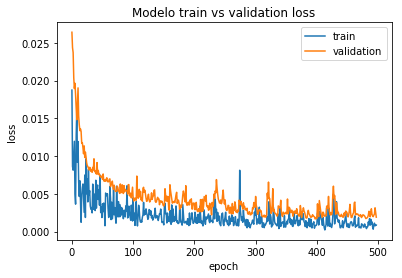

In [45]:
#Plotando
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [46]:
testY_inverse = f_norm.inverse_transform(test.reshape(-1, 1))
print(testY_inverse.shape)

(120, 1)


### Predict

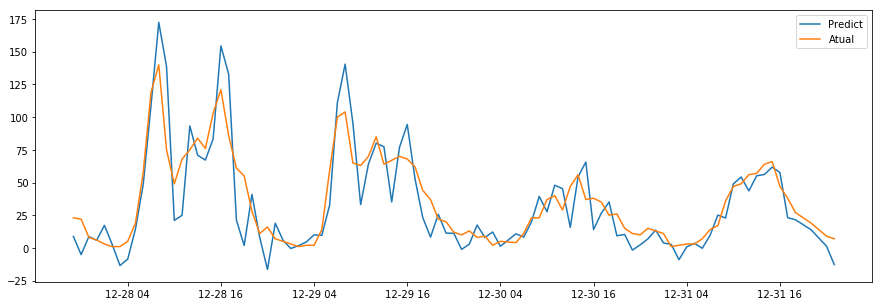

In [47]:
#Reshape test
#testX_ = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Predict
mpred = model.predict_generator(testGenerator)

#Convertendo para valor não normalizado
mpred_inverse = f_norm.inverse_transform(mpred.reshape(-1, 1))
testY_inverse = f_norm.inverse_transform(test.reshape(-1, 1))

#Eixo X do gráfico como data
predictDates = df2.tail(len(mpred_inverse)).index

#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(predictDates, mpred_inverse, label='Predict')
plt.plot(predictDates, testY_inverse[time_steps:len(testY_inverse),], label='Atual')
plt.legend()
plt.show()

<br>No modelo acima sempre prevemos o número de viagens da próxima hora, porém sempre é passado o valor de viagens da hora atual.
<img src="predict1.png">

<br>A seguir utilizaremos a previsão a longo prazo, utilizando o número inicial de viagens como o da hora atual e os seguintes através da saida do predict.
<img src="predict2.png">

### Predict longo prazo

In [38]:
#Quantidade de itens para o set inicial (número de horas)
n = 48

#Valores iniciais para predição
vetX = []

#N itens do set de test
vetX = testX_[0:n,0,0]
np.array(vetX)

#Faz o predict dos N itens de vetx. Ao final de cada iteração insere o ultimo valor predito
#em vetX para um novo predict.
for i in range(len(testX_)-n+1):
    vetX_ = np.reshape(vetX, (vetX.shape[0], 1, 1))
    mpred_lp = model.predict_generator(testGenerator)
    #Insere em vetX o ultimo valor predito de mpredY
    vetX = np.append(vetX, mpred_lp[len(mpred_lp)-1,0])

#Convertendo para valor não normalizado
predY_inverse = f_norm.inverse_transform(mpred_lp.reshape(-1, 1))

#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(predictDates, predY_inverse, label='Predict')
plt.plot(predictDates, testY_inverse[0:96], label='Atual')
plt.legend()
plt.show()

NameError: name 'testX_' is not defined